In [1]:
import json, os, sys
%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import cv2
import tensorflow as tf
from data.loader import load_segmentation, segmentation_process
from utils.session_config import setup_gpus

In [4]:
setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


In [5]:
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
train_ids = np.load("annotations/train_ids.npy")
test_ids = np.load("annotations/val_ids.npy")
coco = COCO("annotations/integrated_annotation.json")

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


# 학습데이터 생성 (파일저장) 이미 파일 생성했을 경우 실행 X

In [6]:
# patch_id = 0 
# for _id in train_ids:
#     print(patch_id)
#     patches, masks = segmentation_process(_id, coco, "detection")
#     for patch, mask in zip(patches, masks):
#         patch_id+=1
#         patch = cv2.resize(patch, [512,512], interpolation=cv2.INTER_NEAREST)
#         mask = cv2.resize(mask, [512,512], interpolation=cv2.INTER_NEAREST)
#         mask = mask[..., np.newaxis]
#         print(patch.shape)
#         print(mask.shape)
#         cv2.imwrite("segmentation/patches/train/{:06d}.png".format(patch_id), patch[:,:,::-1])
#         cv2.imwrite("segmentation/masks/train/{:06d}.png".format(patch_id), mask[:,:,::-1])

In [7]:
# patch_id = 0 
# for _id in test_ids:
#     print(patch_id)
#     patches, masks = segmentation_process(_id, coco, "detection")
#     for patch, mask in zip(patches, masks):
#         patch_id+=1
#         patch = cv2.resize(patch, [512,512], interpolation=cv2.INTER_NEAREST)
#         mask = cv2.resize(mask, [512,512], interpolation=cv2.INTER_NEAREST)
#         mask = mask[..., np.newaxis]
#         print(patch.shape)
#         print(mask.shape)
#         cv2.imwrite("segmentation/patches/test/{:06d}.png".format(patch_id), patch[:,:,::-1])
#         cv2.imwrite("segmentation/masks/test/{:06d}.png".format(patch_id), mask[:,:,::-1])

# data pipeline

In [8]:
split = tf.strings.split

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    mask_path = tf.strings.join([parts[0], "masks", parts[2], parts[3]], separator='/')
    return mask_path

def data_process(file_path):
    patch = tf.io.read_file(file_path)
    patch = tf.image.decode_jpeg(patch, channels=3)
    patch = tf.cast(patch, tf.float32)/255.
    
    mask_path = get_label(file_path)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.where(mask==100, 1.0, 0.0)
    #mask = tf.squeeze(mask, axis=2)
    return patch, mask

In [9]:
split = "train"
train_ds = tf.data.Dataset.list_files("segmentation/patches/{}/*".format(split))
train_ds = train_ds.shuffle(buffer_size=10000, reshuffle_each_iteration=False)
train_ds = train_ds.map(data_process)
for p, q in train_ds.take(1):
    print(p.shape)
    print(q.shape)

(512, 512, 3)
(512, 512, 1)


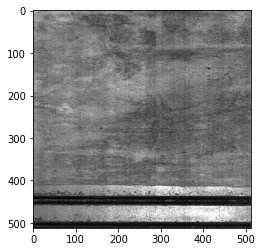

In [10]:
plt.imshow(p)

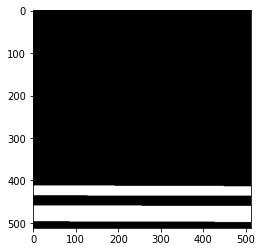

In [11]:
plt.imshow(q, cmap='gray')

In [12]:
split = "test"
test_ds = tf.data.Dataset.list_files("segmentation/patches/{}/*".format(split))
test_ds = test_ds.shuffle(buffer_size=10000, reshuffle_each_iteration=False)
test_ds = test_ds.map(data_process)
for p, q in test_ds.take(1):
    print(p.shape)
    print(q.shape)

(512, 512, 3)
(512, 512, 1)


In [13]:
train_ds = train_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# 모델 빌드 및 학습

In [14]:
model = tf.keras.models.load_model("models/segmentation.h5")

In [15]:
BCE = tf.keras.losses.BinaryCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(patches, masks, model, optimizer, train_loss):
    with tf.GradientTape() as tape:
        preds = model(patches, training=True)
        loss = loss_fn(masks,preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    return loss
@tf.function
def test_step(patches, masks, model, test_loss):
    preds = model(patches, training=False)
    loss = BCE(masks,preds)
    test_loss(loss)
    return loss

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

template = "Epoch {} : train loss {:5f}, val loss {:5f}"
optimizer= tf.keras.optimizers.Adam(learning_rate=1E-5)
EPOCH = 20

log_dir = "logs/segmentation-lrE-5"
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(1, EPOCH+1): 
    train_loss.reset_states()
    test_loss.reset_states()

    for i, (patches, masks) in enumerate(train_ds):
        loss = train_step(patches, masks, model, optimizer, train_loss)
        print("Epoch : {} train_step : {} loss {}".format(epoch, i, loss))
        
    for i, (patches, masks) in enumerate(test_ds):
        loss = test_step(patches, masks, model, test_loss)
        print("Epoch : {} test_step : {} loss {}".format(epoch, i, loss))
    print(template.format(epoch,
                      train_loss.result().numpy(),
                     test_loss.result().numpy()))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('test_loss', test_loss.result().numpy(), step=epoch)
    model.save("checkpoints/segmentation/model-{}.h5".format(epoch))

Epoch : 1 train_step : 0 loss 0.8297526240348816
Epoch : 1 train_step : 1 loss 0.8267791271209717
Epoch : 1 train_step : 2 loss 0.8253774642944336
Epoch : 1 train_step : 3 loss 0.82731032371521
Epoch : 1 train_step : 4 loss 0.8134118914604187
Epoch : 1 train_step : 5 loss 0.8200641870498657
Epoch : 1 train_step : 6 loss 0.8179680109024048
Epoch : 1 train_step : 7 loss 0.8140252828598022
Epoch : 1 train_step : 8 loss 0.8134050369262695
Epoch : 1 train_step : 9 loss 0.8132442831993103
Epoch : 1 train_step : 10 loss 0.8133825063705444
Epoch : 1 train_step : 11 loss 0.8080902099609375
Epoch : 1 train_step : 12 loss 0.8078791499137878
Epoch : 1 train_step : 13 loss 0.8025413751602173
Epoch : 1 train_step : 14 loss 0.8016897439956665
Epoch : 1 train_step : 15 loss 0.8004084229469299
Epoch : 1 train_step : 16 loss 0.7962021827697754
Epoch : 1 train_step : 17 loss 0.795896053314209
Epoch : 1 train_step : 18 loss 0.793923020362854
Epoch : 1 train_step : 19 loss 0.7931956052780151
Epoch : 1 trai